In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import NNConv, GCNConv, global_mean_pool

# Visualization
import matplotlib.pyplot as plt

# Import Data

In [2]:
# List of file paths
file_paths = [
    '../data/ASPEDv1.1-flow/523_flow_final.csv',
    '../data/ASPEDv1.1-flow/601_flow_final.csv',
    '../data/ASPEDv1.1-flow/607_flow_final.csv',
    '../data/ASPEDv1.1-flow/621_flow_final.csv',
    '../data/ASPEDv1.1-flow/628_flow_final.csv'
]

def convert_datetime(column):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S', '%d-%m-%Y %H:%M', ...]  # List all expected formats

    for fmt in formats:
        try:
            return pd.to_datetime(column, format=fmt)
        except ValueError:
            continue
    return pd.to_datetime(column, errors='coerce')  # Fallback to coercion in case all formats fail

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['timestamp'] = convert_datetime(df['timestamp'])
    return df

dataframes = [load_data(file) for file in file_paths]
combined_data = pd.concat(dataframes, ignore_index=True)

In [3]:
# Import pedestrian data
#cadell524 = pd.read_csv("./ASPEDv1.1/5-24-Cadell-merged.csv")

# Dropping 1, 3, and 9m columns for simplicity.
del_cols = []
num_locations = 6

for loc in range(1, num_locations +1):
    for meter in ['1m', '3m', '6m']:
        del_cols.append(f'recorder{loc}_{meter}')

combined_data = combined_data.drop(del_cols, axis=1)

combined_data.columns = ["timestamp", "frame", "recorder1", "recorder2", "recorder3", "recorder4", "recorder5", "recorder6",
                        "Incremental_DOWN", "Incremental_UP", "Total_DOWN", "Total_UP"]

# Filter out rows where time is not between 7 AM and 7 PM
# Ensure 'timestamp' is a datetime object
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])


combined_data.head()

,timestamp,frame,recorder1,recorder2,recorder3,recorder4,recorder5,recorder6,Incremental_DOWN,Incremental_UP,Total_DOWN,Total_UP
0,2023-05-24 11:33:00,0,0,1,0,0,1,0,0,0,0,0
1,2023-05-24 11:33:01,1,0,1,0,0,0,0,0,0,0,0
2,2023-05-24 11:33:02,2,0,0,1,0,0,0,0,0,0,0
3,2023-05-24 11:33:03,3,0,0,0,0,0,0,0,0,0,0
4,2023-05-24 11:33:04,4,0,0,0,0,0,0,0,0,0,0


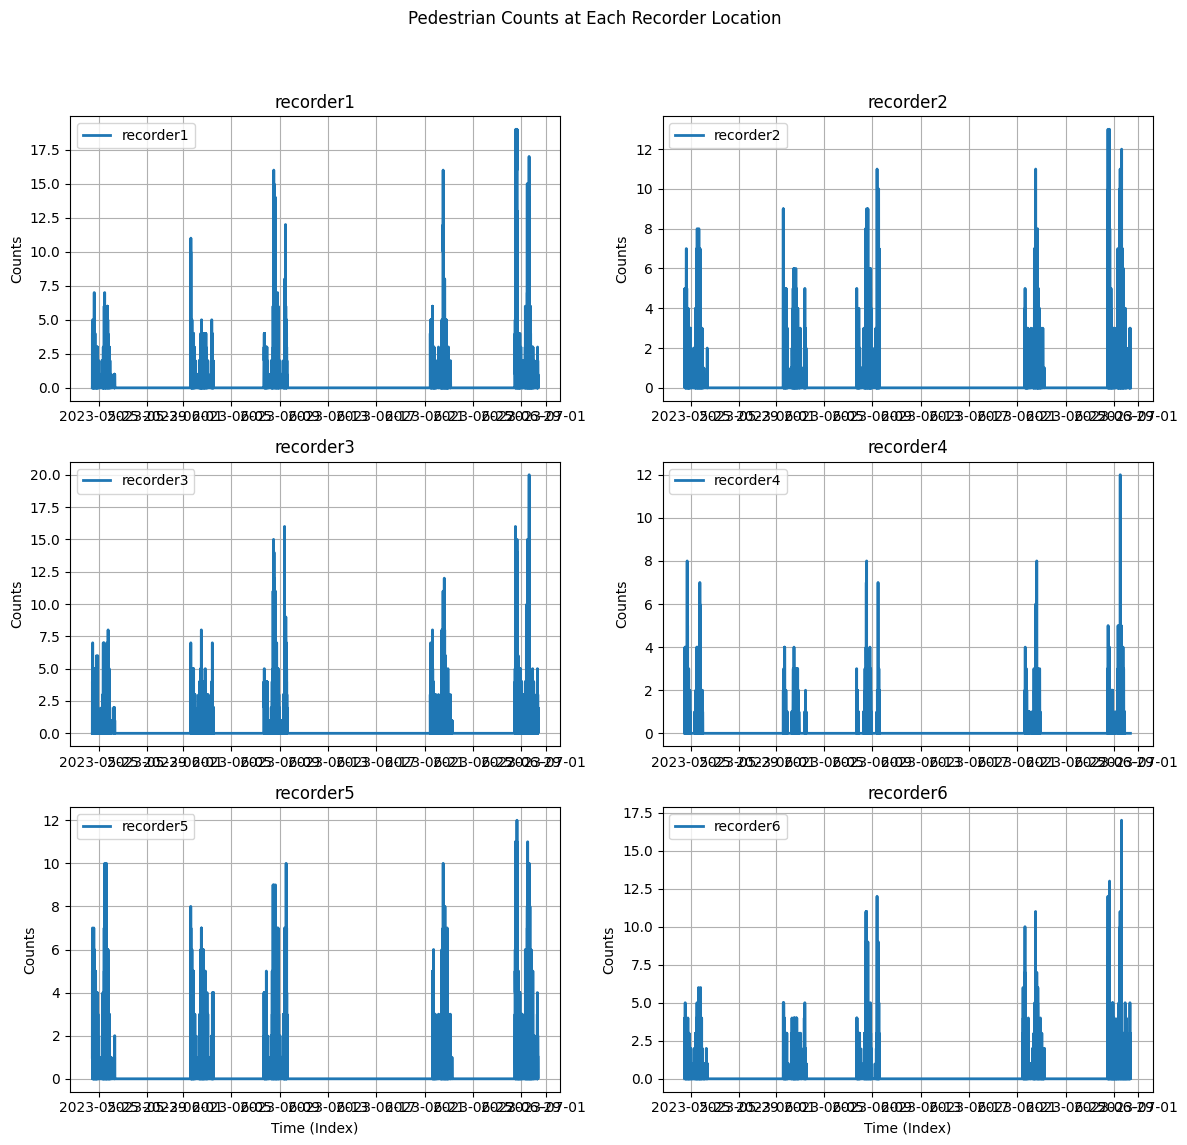

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))  # 3 rows, 2 columns
fig.suptitle('Pedestrian Counts at Each Recorder Location')

recorders = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']
for i, recorder in enumerate(recorders):
    # Calculate which row and column to place each subplot
    row = i // 2  # Integer division to determine row
    col = i % 2   # Modulus to determine column
    axs[row, col].plot(combined_data['timestamp'], combined_data[recorder], label=f'{recorder}', linewidth=2)
    axs[row, col].set_title(f'{recorder}')
    axs[row, col].set_ylabel('Counts')
    axs[row, col].grid(True)
    axs[row, col].legend()

# Setting x-labels for the bottom plots
axs[2, 0].set_xlabel('Time (Index)')
axs[2, 1].set_xlabel('Time (Index)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

In [5]:
# Filtering out rows between 7 PM (19:00) to 7 AM (07:00)
combined_data = combined_data[
    (combined_data['timestamp'].dt.hour >= 7) & (combined_data['timestamp'].dt.hour < 19)
]

# Filter out if all recorders have 0 pedestrians
# Columns that contain the pedestrian counts for each recorder
recorder_columns = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']

# Filter out rows where all specified columns have zero values
# cadell524 = cadell524.loc[~(cadell524[recorder_columns] == 0).all(axis=1)]

print(combined_data.shape)

(378548, 12)


In [6]:
# Ensure the timestamp column is in datetime format
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])
combined_data['hour'] = combined_data['timestamp'].dt.hour
combined_data['day_of_week'] = combined_data['timestamp'].dt.dayofweek

combined_data.head()

,timestamp,frame,recorder1,recorder2,recorder3,recorder4,recorder5,recorder6,Incremental_DOWN,Incremental_UP,Total_DOWN,Total_UP,hour,day_of_week
0,2023-05-24 11:33:00,0,0,1,0,0,1,0,0,0,0,0,11,2
1,2023-05-24 11:33:01,1,0,1,0,0,0,0,0,0,0,0,11,2
2,2023-05-24 11:33:02,2,0,0,1,0,0,0,0,0,0,0,11,2
3,2023-05-24 11:33:03,3,0,0,0,0,0,0,0,0,0,0,11,2
4,2023-05-24 11:33:04,4,0,0,0,0,0,0,0,0,0,0,11,2


# Aggregate to N second average chunks

In [7]:
# Sample DataFrame creation
# Assuming 'timestamp' is a column with datetime data on second intervals
combined_data['timestamp'] = pd.date_range(start='2023-05-24 11:33:00', periods=len(combined_data), freq='S')
combined_data.set_index('timestamp', inplace=True)

# Define custom aggregation functions for each column
aggregations = {
    'recorder1': 'mean',  # Replace 'location1' to 'location6' with your actual column names
    'recorder2': 'mean',
    'recorder3': 'mean',
    'recorder4': 'mean',
    'recorder5': 'mean',
    'recorder6': 'mean',
    'hour': 'first',
    'day_of_week': 'first',
    'Incremental_UP': 'sum',
    'Incremental_DOWN': 'sum',
    'Total_UP': 'mean',
    'Total_DOWN': 'mean'
}

# Resample and compute the mean for each 5-second interval
aggregated_data_2s = combined_data.resample('2S').agg(aggregations)
aggregated_data_3s = combined_data.resample('3S').agg(aggregations)
aggregated_data_5s = combined_data.resample('5S').agg(aggregations)
aggregated_data_10s = combined_data.resample('10S').agg(aggregations)

# Reset the index if you want 'timestamp' back as a column
aggregated_data_2s.reset_index(inplace=True)
aggregated_data_3s.reset_index(inplace=True)
aggregated_data_5s.reset_index(inplace=True)
aggregated_data_10s.reset_index(inplace=True)

# Now, aggregated_data holds the averaged values for each 5-second chunk
aggregated_data_2s.head()

/var/folders/v5/9zhxcvtx7rd3kvh2dpmps8wr0000gn/T/ipykernel_88222/880490792.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  combined_data['timestamp'] = pd.date_range(start='2023-05-24 11:33:00', periods=len(combined_data), freq='S')
/var/folders/v5/9zhxcvtx7rd3kvh2dpmps8wr0000gn/T/ipykernel_88222/880490792.py:23: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  aggregated_data_2s = combined_data.resample('2S').agg(aggregations)
/var/folders/v5/9zhxcvtx7rd3kvh2dpmps8wr0000gn/T/ipykernel_88222/880490792.py:24: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  aggregated_data_3s = combined_data.resample('3S').agg(aggregations)
/var/folders/v5/9zhxcvtx7rd3kvh2dpmps8wr0000gn/T/ipykernel_88222/880490792.py:25: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  aggregated_data_5s = combin

,timestamp,recorder1,recorder2,recorder3,recorder4,recorder5,recorder6,hour,day_of_week,Incremental_UP,Incremental_DOWN,Total_UP,Total_DOWN
0,2023-05-24 11:33:00,0.0,1.0,0.0,0.0,0.5,0.0,11,2,0,0,0.0,0.0
1,2023-05-24 11:33:02,0.0,0.0,0.5,0.0,0.0,0.0,11,2,0,0,0.0,0.0
2,2023-05-24 11:33:04,0.5,0.0,0.0,0.0,0.0,0.0,11,2,0,0,0.0,0.0
3,2023-05-24 11:33:06,1.0,0.0,0.5,0.0,0.0,0.0,11,2,0,0,0.0,0.0
4,2023-05-24 11:33:08,3.0,0.0,0.0,0.0,0.0,0.0,11,2,0,0,0.0,0.0


In [95]:
# 'timestamp' is the first column and the rest are recorder counts
timestamps_2s = aggregated_data_2s['timestamp']
timestamps_3s = aggregated_data_3s['timestamp']
timestamps_5s = aggregated_data_5s['timestamp']
timestamps_10s = aggregated_data_10s['timestamp']

# Selecting features for the model
# Selecting features for the model
date_columns = ['hour'] 

simple = True
if simple:
    recorder_columns = ['recorder1','recorder2', 'recorder5']
else:
    recorder_columns = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']
    
video_columns = ['Incremental_UP', 'Incremental_DOWN']
target_columns = ['Incremental_UP', 'Incremental_DOWN']

In [96]:
data = aggregated_data_5s

In [97]:
# Create the feature (X) and target (Y) tensor
all_features = data[recorder_columns + date_columns + video_columns]
target_features = data[target_columns]

all_features_tensor = torch.tensor(all_features.values, dtype=torch.float)
target_tensor = torch.tensor(target_features.values, dtype=torch.float)

print(all_features)
print(target_features)

       recorder1  recorder2  recorder5  hour  Incremental_UP  Incremental_DOWN
0            0.0        0.4   0.200000    11               0                 0
1            1.8        0.0   0.000000    11               0                 0
2            2.0        0.0   0.000000    11               0                 0
3            1.6        0.0   0.000000    11               0                 0
4            2.6        0.0   0.000000    11               0                 0
...          ...        ...        ...   ...             ...               ...
75705        0.0        0.0   0.000000     8               0                 0
75706        0.0        0.0   0.000000     8               0                 0
75707        0.0        0.0   0.000000     8               0                 0
75708        0.0        0.0   0.000000     8               0                 0
75709        0.0        0.0   0.333333     8               0                 0

[75710 rows x 6 columns]
       Incremental_UP  Inc

# Include Distance Information: Adjacency Matrix

In [98]:
# Step 2: Load the adjacency matrix
adjacency_path = '../data/KlausCourtyard_AdjacencyMatrix.csv'
adjacency_data = pd.read_csv(adjacency_path)

adjacency_data.head()

,from,to,distance_m
0,recorder1,recorder1,0.00
1,recorder1,recorder2,14.30
2,recorder1,recorder3,13.75
3,recorder1,recorder4,28.50
4,recorder1,recorder5,26.00


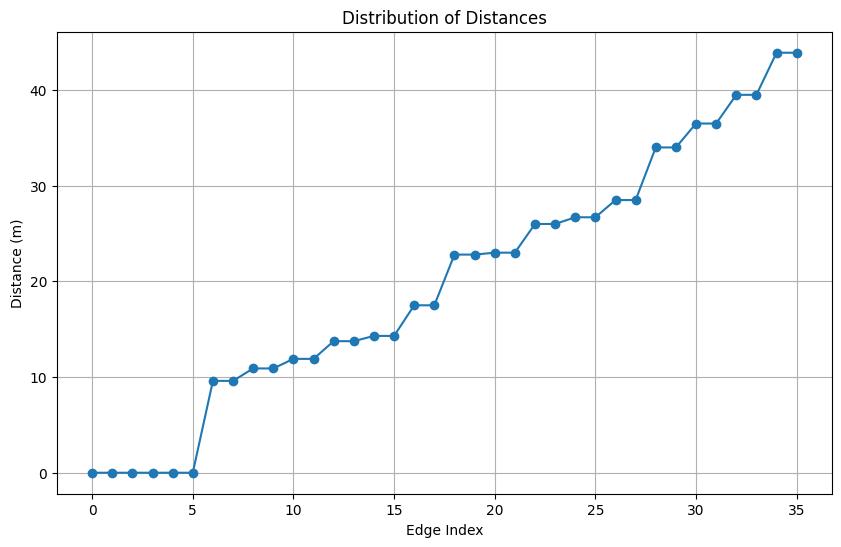

In [99]:
# Plot the distribution of distance_m
plt.figure(figsize=(10, 6))
plt.plot(sorted(adjacency_data['distance_m']), marker='o')
plt.title('Distribution of Distances')
plt.xlabel('Edge Index')
plt.ylabel('Distance (m)')
plt.grid(True)
plt.show()

In [100]:
recorder_to_index = {name: idx for idx, name in enumerate(recorder_columns)}
print(recorder_to_index)

# Filter adjacency matrix to only include edges with 'from' or 'to' being recorder 2 or 5
adjacency_data_filtered = adjacency_data[(adjacency_data['from'].isin(recorder_columns)) & (adjacency_data['to'].isin(recorder_columns))]

# Create the edge index from the adjacency matrix
edge_index = adjacency_data_filtered.apply(
    lambda row: torch.tensor([recorder_to_index[row['from']], recorder_to_index[row['to']]], dtype=torch.long), 
    axis=1).tolist()
edge_index = torch.stack(edge_index).t().contiguous()

print(edge_index.shape)
print(edge_index)

{'recorder1': 0, 'recorder2': 1, 'recorder5': 2}
torch.Size([2, 9])
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
        [0, 1, 2, 0, 1, 2, 0, 1, 2]])


In [101]:
def gaussian_kernel(distance, sigma=1.0):
    """Apply Gaussian kernel to a given distance."""
    return np.exp(- (distance ** 2) / (2 * sigma ** 2))

sigma = adjacency_data_filtered['distance_m'].std()
adjacency_data_filtered['weight'] = gaussian_kernel(adjacency_data_filtered['distance_m'], sigma=sigma)

adjacency_data_filtered

/var/folders/v5/9zhxcvtx7rd3kvh2dpmps8wr0000gn/T/ipykernel_88222/777559135.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjacency_data_filtered['weight'] = gaussian_kernel(adjacency_data_filtered['distance_m'], sigma=sigma)


,from,to,distance_m,weight
0,recorder1,recorder1,0.0,1.000000
1,recorder1,recorder2,14.3,0.374653
4,recorder1,recorder5,26.0,0.038950
6,recorder2,recorder1,14.3,0.374653
7,recorder2,recorder2,0.0,1.000000
10,recorder2,recorder5,11.9,0.506683
24,recorder5,recorder1,26.0,0.038950
25,recorder5,recorder2,11.9,0.506683
28,recorder5,recorder5,0.0,1.000000


In [102]:
# Function to filter edges
k_values = [20, 30, 40, 50]  # Different values of k for creating different adjacency datasets

def filter_edges(adjacency_data_filtered, k):
    return adjacency_data_filtered[adjacency_data_filtered['distance_m'] <= k]

filtered_adjacency_data = {k: filter_edges(adjacency_data_filtered, k) for k in k_values}

# Function to create edge_index tensor
def create_edge_index(df):
    edge_index_list = df.apply(
        lambda row: torch.tensor([recorder_to_index[row['from']], recorder_to_index[row['to']]], dtype=torch.long), 
        axis=1).tolist()
    return torch.stack(edge_index_list).t().contiguous()

edge_indices = {k: create_edge_index(df) for k, df in filtered_adjacency_data.items()}

In [103]:
edge_indices

{20: tensor([[0, 0, 1, 1, 1, 2, 2],
         [0, 1, 0, 1, 2, 1, 2]]),
 30: tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
         [0, 1, 2, 0, 1, 2, 0, 1, 2]]),
 40: tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
         [0, 1, 2, 0, 1, 2, 0, 1, 2]]),
 50: tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
         [0, 1, 2, 0, 1, 2, 0, 1, 2]])}

In [104]:
# Function to create edge_attr tensor
def create_edge_attr(df):
    return torch.tensor(df[['weight']].values, dtype=torch.float)

edge_attrs = {k: create_edge_attr(df) for k, df in filtered_adjacency_data.items()}

# Print the resulting tensors for each k value
for k in k_values:
    print(f"For k = {k}:")
    print("edge_index shape:")
    print(edge_indices[k].shape)
    #print("edge_attr:")
    #print(edge_attrs[k])
    print()

For k = 20:
edge_index shape:
torch.Size([2, 7])

For k = 30:
edge_index shape:
torch.Size([2, 9])

For k = 40:
edge_index shape:
torch.Size([2, 9])

For k = 50:
edge_index shape:
torch.Size([2, 9])



In [56]:
print(edge_indices[20])
print(edge_attrs[20])

tensor([[0, 0, 1, 1, 1, 2, 2],
        [0, 1, 0, 1, 2, 1, 2]])
tensor([[1.0000],
        [0.3747],
        [0.3747],
        [1.0000],
        [0.5067],
        [0.5067],
        [1.0000]])


# Data Preparation - Normalization and Train-Test Split

In [105]:
# Min-max scaling of features (pedestrian counts)
all_features_np = all_features_tensor.numpy()
target_np = target_tensor.numpy()

def min_max_scale(data):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    return (data - data_min) / (data_max - data_min), data_min, data_max

scaled_features, features_min, features_max = min_max_scale(all_features_np)
scaled_targets, targets_min, targets_max = min_max_scale(target_np)

In [106]:
print("Min of features:", features_min)
print("Max of features:", features_max)
print("Min of targets:", targets_min)
print("Max of features:", targets_max)

Min of features: [0. 0. 0. 7. 0. 0.]
Max of features: [17.8 10.6 10.2 18.   5.   6. ]
Min of targets: [0. 0.]
Max of features: [5. 6.]


### Data Descriptive Table

In [107]:
total_pedestrians = np.sum(target_np, axis=1)
print(total_pedestrians)

[0. 0. 0. ... 0. 0. 0.]


In [32]:
total_pedestrians = np.sum(target_np, axis=1)
print(total_pedestrians)

# Time of day is the seventh column
time_of_day = all_features_np[:, 6].astype(int)  # Ensure it's integer for grouping
print(time_of_day)

# Create a matrix to store counts for each pedestrian number per hour
max_pedestrians = int(np.max(total_pedestrians))  # Get the maximum number of pedestrians in any frame
# Clipping the pedestrian count at 6 for aggregation
clipped_max = min(6, max_pedestrians)
print(max_pedestrians)

hourly_pedestrian_distribution = np.zeros((12, clipped_max + 1))  # +1 because we start at zero pedestrians

# Fill the matrix with counts
for hour in range(7,19):
    hour_indices = np.where(time_of_day == hour)[0]
    if hour_indices.size > 0:
        hour_pedestrians = total_pedestrians[hour_indices]
        for count in range(clipped_max + 1):
            if count == clipped_max:
                # Aggregate all counts of 6 and more into one category
                hourly_pedestrian_distribution[hour - 7, count] = np.sum(hour_pedestrians >= count)
            else:
                hourly_pedestrian_distribution[hour - 7, count] = np.sum(hour_pedestrians == count)
                
print(hourly_pedestrian_distribution)

[0. 0. 0. ... 0. 0. 0.]
[11 11 11 ...  8  8  8]
6
[[6.413e+03 6.000e+01 6.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [5.643e+03 8.300e+01 1.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [4.862e+03 1.590e+02 1.600e+01 1.000e+00 1.000e+00 1.000e+00 0.000e+00]
 [4.880e+03 1.660e+02 2.100e+01 6.000e+00 2.000e+00 1.000e+00 0.000e+00]
 [6.157e+03 3.250e+02 7.300e+01 1.600e+01 3.000e+00 2.000e+00 0.000e+00]
 [6.209e+03 4.970e+02 1.080e+02 3.200e+01 1.100e+01 5.000e+00 2.000e+00]
 [6.028e+03 3.650e+02 6.900e+01 1.600e+01 2.000e+00 0.000e+00 0.000e+00]
 [5.546e+03 2.980e+02 6.700e+01 1.100e+01 4.000e+00 0.000e+00 0.000e+00]
 [5.953e+03 3.590e+02 8.100e+01 3.100e+01 6.000e+00 2.000e+00 0.000e+00]
 [6.351e+03 2.880e+02 4.700e+01 1.000e+01 0.000e+00 0.000e+00 0.000e+00]
 [6.892e+03 2.500e+02 5.100e+01 4.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [6.964e+03 1.830e+02 4.500e+01 7.000e+00 1.000e+00 0.000e+00 0.000e+00]]


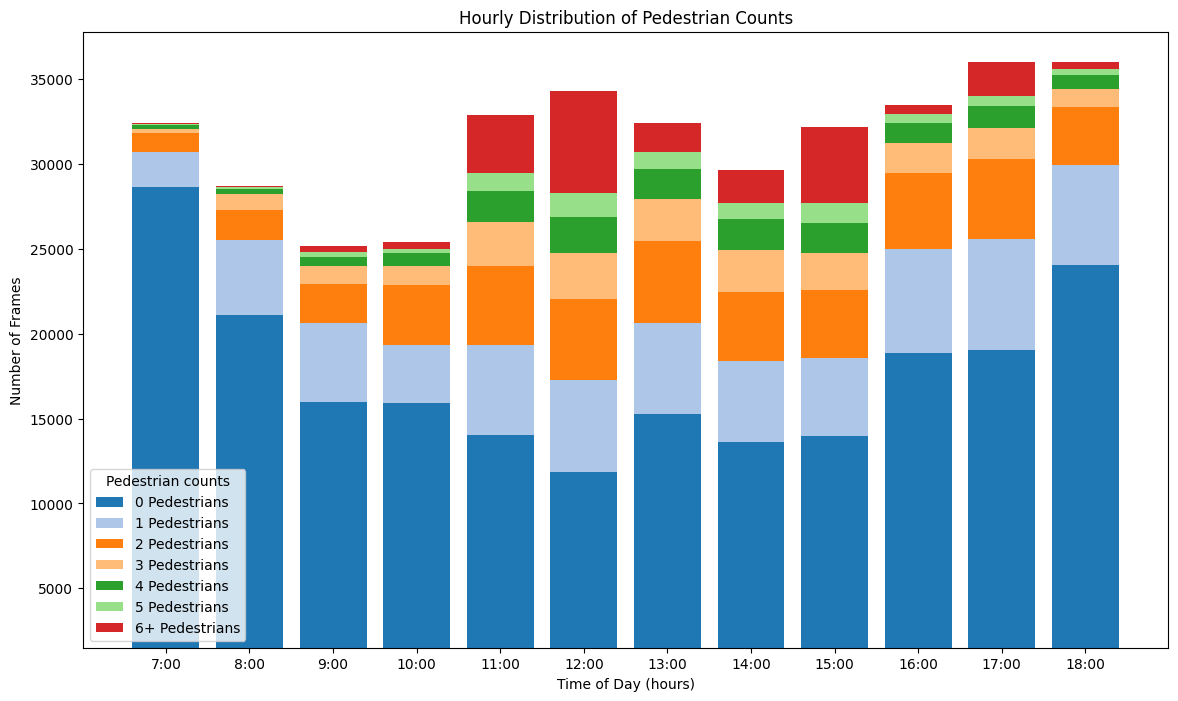

In [65]:
# colors = plt.cm.viridis(np.linspace(0, 1, clipped_max + 1))
# Choose a bright and distinct color palette
colors = plt.get_cmap('tab20').colors  # 'tab20' provides 20 distinct colors

fig, ax = plt.subplots(figsize=(14, 8))

# Stacked bar for each pedestrian count at each time
for i in range(clipped_max + 1):
    bottom = np.sum(hourly_pedestrian_distribution[:, :i], axis=1) if i > 0 else None
    label = f'{i}+' if i == clipped_max else f'{i}'
    ax.bar(range(7, 19), hourly_pedestrian_distribution[:, i], bottom=bottom, color=colors[i], label=f'{label} Pedestrians')

ax.set_xlabel('Time of Day (hours)')
ax.set_ylabel('Number of Frames')
ax.set_title('Hourly Distribution of Pedestrian Counts')
ax.set_xticks(range(7, 19))
ax.set_xticklabels([f"{h}:00" for h in range(7, 19)])
ax.legend(title="Pedestrian counts")
ax.set_ylim([1500, ax.get_ylim()[1]])  # Start y-axis at 10,000

plt.show()

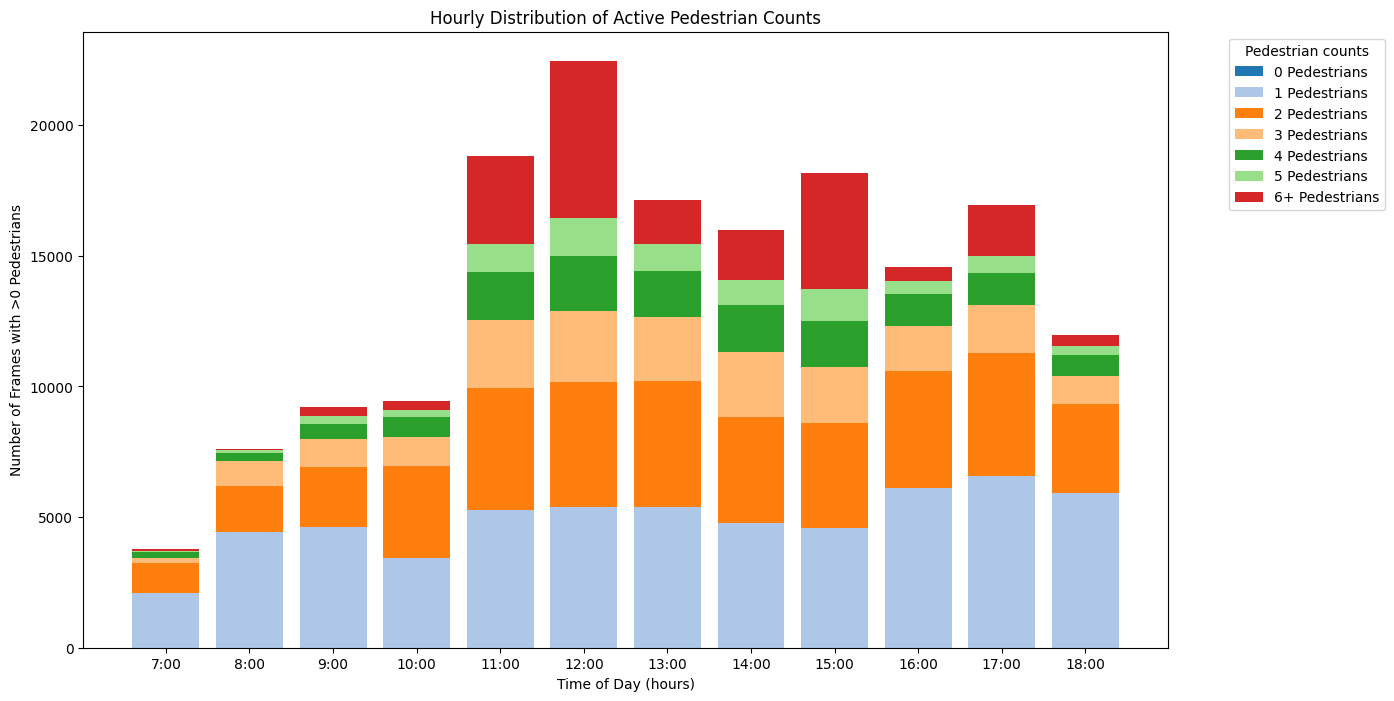

In [66]:
# Filter only frames with more than 0 pedestrians
non_zero_frames = total_pedestrians > 0
non_zero_pedestrians = total_pedestrians[non_zero_frames]
non_zero_hours = time_of_day[non_zero_frames]

# Determine the highest pedestrian count in non-zero frames for color mapping
max_pedestrians_non_zero = int(np.max(non_zero_pedestrians))
clipped_max_non_zero = min(6, max_pedestrians_non_zero)  # We continue to clip at 6+

# Setup the count distribution matrix for these hours (12 hours, 7 AM to 6 PM)
hourly_pedestrian_distribution_non_zero = np.zeros((12, clipped_max_non_zero + 1))

for hour in range(7, 19):  # 7 AM to 6 PM
    hour_indices = np.where(non_zero_hours == hour)[0]
    if hour_indices.size > 0:
        hour_pedestrians = non_zero_pedestrians[hour_indices]
        for count in range(clipped_max_non_zero + 1):
            if count == clipped_max_non_zero:
                # Aggregate all counts of 6 and more into one category
                hourly_pedestrian_distribution_non_zero[hour - 7, count] = np.sum(hour_pedestrians >= count)
            else:
                hourly_pedestrian_distribution_non_zero[hour - 7, count] = np.sum(hour_pedestrians == count)

# Colors for the plot
colors_non_zero = plt.get_cmap('tab20').colors

fig, ax = plt.subplots(figsize=(14, 8))

# Stacked bar for each pedestrian count at each time
for i in range(clipped_max_non_zero + 1):
    bottom = np.sum(hourly_pedestrian_distribution_non_zero[:, :i], axis=1) if i > 0 else None
    label = f'{i}+' if i == clipped_max_non_zero else f'{i}'
    ax.bar(range(7, 19), hourly_pedestrian_distribution_non_zero[:, i], bottom=bottom, color=colors_non_zero[i], label=f'{label} Pedestrians')

ax.set_xlabel('Time of Day (hours)')
ax.set_ylabel('Number of Frames with >0 Pedestrians')
ax.set_title('Hourly Distribution of Active Pedestrian Counts')
ax.set_xticks(range(7, 19))
ax.set_xticklabels([f"{h}:00" for h in range(7, 19)])
ax.legend(title="Pedestrian counts", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [67]:
scaled_targets_df = pd.DataFrame(scaled_targets, columns=recorder_columns) 

def reverse_min_max_scale(scaled_data, data_min, data_max):
    """Reverses the min-max scaling applied to the data."""
    return (scaled_data * (data_max - data_min)) + data_min

scaled_targets_df = reverse_min_max_scale(scaled_targets_df, targets_min, targets_max)

def compute_summary_statistics(df):
    
    summary_stats = pd.DataFrame({
        'Mean': df.mean(),
        'STD': df.std(),
        'Min': df.min(),
        'Max': df.max(),
        'Median': df.median(),
        'Range': df.max() - df.min()  # Range as max - min
    })
    return summary_stats

def compute_combined_statistics(df):
    # Flatten the DataFrame to a single Series of values for all recorders
    all_values = df.values.flatten()
    
    # Compute statistics
    mean = np.mean(all_values)
    std = np.std(all_values)
    minimum = np.min(all_values)
    maximum = np.max(all_values)
    median = np.median(all_values)
    data_range = maximum - minimum
    
    # Create a DataFrame for display
    summary_stats = pd.DataFrame({
        'Mean': [mean],
        'STD': [std],
        'Min': [minimum],
        'Max': [maximum],
        'Median': [median],
        'Range': [data_range]
    }, index=['All Recorders'])
    
    return summary_stats

# Compute summaries for features and targets
targets_summary = compute_summary_statistics(scaled_targets_df)
targets_combined_summary = compute_combined_statistics(scaled_targets_df)

print("\nTargets Summary:")
print(len(scaled_targets_df))

targets_summary
targets_combined_summary


Targets Summary:
378548


,Mean,STD,Min,Max,Median,Range
All Recorders,0.219779,0.758189,0.0,20.0,0.0,20.0


### Make Sequential Data for Time Series Prediction

In [128]:
# Define sequence length
sequence_length = 10  # 10 time steps per sequence
date_id = 4

def create_feature_target_sequences(data, target_data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        # Check if the time of day is continuous
        time_of_day_seq = data[i:(i + seq_length), date_id-1]  # Assuming the time of day is the last feature (4th feature)
        
        # Compare consecutive time steps, check if they are 1 unit apart
        if np.all(np.diff(time_of_day_seq) == 1) or np.all(np.diff(time_of_day_seq) == 0):
            # Add feature sequence
            xs.append(data[i:(i + seq_length)])
            
            # Add the corresponding target sequence
            summed_sequence = np.sum(target_data[i:(i + seq_length)], axis=0)
            ys.append(summed_sequence)
        
    return np.array(xs), np.array(ys)

# Assuming scaled_features contain the full set of features and scaled_targets is the target data
sequential_features, sequential_targets = create_feature_target_sequences(scaled_features, scaled_targets, sequence_length)

print(len(sequential_features))
print(len(sequential_targets))

# Remove the last sequence from the feature tensor if its corresponding target does not exist
if len(sequential_features) > len(sequential_targets):
    sequential_features = sequential_features[:-1]

74719
74719


In [129]:
print(sequential_features[0])
print(sequential_targets[0])

[[0.         0.03773585 0.01960784 0.36363637 0.         0.        ]
 [0.10112359 0.         0.         0.36363637 0.         0.        ]
 [0.11235955 0.         0.         0.36363637 0.         0.        ]
 [0.08988765 0.         0.         0.36363637 0.         0.        ]
 [0.14606741 0.         0.         0.36363637 0.         0.        ]
 [0.05617978 0.         0.         0.36363637 0.         0.        ]
 [0.         0.         0.         0.36363637 0.         0.        ]
 [0.         0.         0.         0.36363637 0.         0.        ]
 [0.15730338 0.         0.         0.36363637 0.         0.        ]
 [0.14606741 0.01886792 0.         0.36363637 0.         0.        ]]
[0. 0.]


# Split Dataset Train (60%), Validation (30%), Test (10%)

In [130]:
# Calculate the number of sequences in the dataset, same for audio and video
num_sequences = len(sequential_features)  

# Calculate the split index
split_index = int(num_sequences * 0.9)  # 60% of the data for training
print(split_index)

# Split the features 90%
trainvalid_features = sequential_features[:split_index]
test_features = sequential_features[split_index:]

# Split by audio and video
audio_trainvalid_features = trainvalid_features[:,:,:4]
video_trainvalid_features = trainvalid_features[:,:,3:]

audio_test_features = test_features[:,:,:4]
video_test_features = test_features[:,:,3:]

# Split the targets 10% 
trainvalid_targets = sequential_targets[:split_index]
test_targets = sequential_targets[split_index:]

print(f"Audio Training features shape: {audio_trainvalid_features.shape}")
print(f"Video Training features shape: {video_trainvalid_features.shape}")
print(f"Audio + Video Training features shape: {trainvalid_features.shape}")
print(f"Training targets shape: {trainvalid_targets.shape}")

print(f"Audio Testing features shape: {audio_test_features.shape}")
print(f"Video Testing features shape: {video_test_features.shape}")
print(f"Audio + Video Testing shape: {trainvalid_features.shape}")
print(f"Testing targets shape: {test_targets.shape}")

67247
Audio Training features shape: (67247, 10, 4)
Video Training features shape: (67247, 10, 3)
Audio + Video Training features shape: (67247, 10, 6)
Training targets shape: (67247, 2)
Audio Testing features shape: (7472, 10, 4)
Video Testing features shape: (7472, 10, 3)
Audio + Video Testing shape: (67247, 10, 6)
Testing targets shape: (7472, 2)


# Balance Training and Validation Dataset

In [111]:
print(video_trainvalid_features[200][:, 1:])
np.sum(video_trainvalid_features[200][:, 1:])

[[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.16666667]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]


np.float32(0.16666667)

In [131]:
# Filter out sequences where all recorders have zero pedestrians across all 10 frames 
valid_indices = [i for i, seq in enumerate(video_trainvalid_features) if not np.sum(seq[:, 1:]) == 0]
zero_indices = [i for i, seq in enumerate(video_trainvalid_features) if np.sum(seq[:, 1:]) == 0]

# Use valid_indices to filter both features and targets
nonzero_audio_features = audio_trainvalid_features[valid_indices]
nonzero_video_features = video_trainvalid_features[valid_indices]
nonzero_features = trainvalid_features[valid_indices]
nonzero_targets = trainvalid_targets[valid_indices]

# Use valid_indices to filter both features and targets
allzero_audio_features = audio_trainvalid_features[zero_indices]
allzero_video_features = video_trainvalid_features[zero_indices]
allzero_features = trainvalid_features[zero_indices]
allzero_targets = trainvalid_targets[zero_indices]

In [132]:
# Determine the number of samples to take from each group
# num_samples = min(len(nonzero_features), len(allzero_features))
num_samples = len(nonzero_features)

print("length of Non-zero sequences: ", len(nonzero_features))
print("length of All-zero sequences: ", len(allzero_features))

length of Non-zero sequences:  24190
length of All-zero sequences:  43057


In [133]:
# Generate random indices for sampling without replacement
zero_indices = np.random.choice(len(allzero_audio_features), int(num_samples/2), replace=False)

# non_zero_indices = np.random.choice(len(nonzero_audio_features), num_samples, replace=False)

# Sample features and targets based on the indices
allzero_audio_features_sampled = allzero_audio_features[zero_indices]
allzero_video_features_sampled = allzero_video_features[zero_indices]
allzero_features_sampled = allzero_features[zero_indices]

# nonzero_features_sampled = nonzero_features[non_zero_indices]

allzero_targets_sampled = allzero_targets[zero_indices]
# nonzero_targets_sampled = nonzero_targets[non_zero_indices]

print("length of Non-zero samples: ", len(nonzero_targets))
print("length of All-zero samples: ", len(allzero_targets_sampled))

# Combine the samples to form new feature and target sets
balanced_audio_features = np.concatenate([allzero_audio_features_sampled, nonzero_audio_features], axis=0)
balanced_video_features = np.concatenate([allzero_video_features_sampled, nonzero_video_features], axis=0)
balanced_features = np.concatenate([allzero_features_sampled, nonzero_features], axis=0)
balanced_targets = np.concatenate([allzero_targets_sampled, nonzero_targets], axis=0)

# Shuffle the combined dataset to randomize the order of sequences
# indices = np.arange(balanced_features.shape[0])
# np.random.shuffle(indices)
# balanced_features = balanced_features[indices]
# balanced_targets = balanced_targets[indices]

# Debugging and validation
print("Balanced audio features shape:", balanced_audio_features.shape)
print("Balanced video features shape:", balanced_video_features.shape)
print("Balanced audio + video features shape:", balanced_features.shape)
print("Balanced targets shape:", balanced_targets.shape)

length of Non-zero samples:  24190
length of All-zero samples:  12095
Balanced audio features shape: (36285, 10, 4)
Balanced video features shape: (36285, 10, 3)
Balanced audio + video features shape: (36285, 10, 6)
Balanced targets shape: (36285, 2)


In [134]:
balanced_audio_features_tensor = torch.tensor(balanced_audio_features, dtype=torch.float)
balanced_video_features_tensor = torch.tensor(balanced_video_features, dtype=torch.float)
balanced_features_tensor = torch.tensor(balanced_features, dtype=torch.float)
balanced_targets_tensor = torch.tensor(balanced_targets, dtype=torch.float)

In [ ]:
balanced_targets_df = pd.DataFrame(balanced_targets, columns=recorder_columns) 
balanced_targets_df = reverse_min_max_scale(balanced_targets_df, targets_min, targets_max)

# Compute summaries for features and targets
balanced_summary = compute_summary_statistics(balanced_targets_df)
balanced_combined_summary = compute_combined_statistics(balanced_targets_df)

print("\nFiltered Summary:")
print(len(balanced_targets_df))

balanced_summary
balanced_combined_summary

# Splitting Dataset    

### Since the dataset has temporal dimension, I should not randomly shuffle. 

In [135]:
# Calculate the number of sequences in the dataset
num_sequences = len(balanced_audio_features_tensor)

# Calculate the split index
split_index = int(num_sequences * 0.66)  # 59.4% of the total data for training

# Split the features
audio_train_features = balanced_audio_features_tensor[:split_index]
audio_validation_features = balanced_audio_features_tensor[split_index:]

video_train_features = balanced_video_features_tensor[:split_index]
video_validation_features = balanced_video_features_tensor[split_index:]

train_features = balanced_features_tensor[:split_index]
validation_features = balanced_features_tensor[split_index:]

# Split the targets
train_targets = balanced_targets_tensor[:split_index]
validation_targets = balanced_targets_tensor[split_index:]

audio_test_features = torch.tensor(audio_test_features, dtype=torch.float)
video_test_features = torch.tensor(video_test_features, dtype=torch.float)
test_features = torch.tensor(test_features, dtype = torch.float)
test_targets = torch.tensor(test_targets, dtype=torch.float)

print(f"Audio - Training features shape: {audio_train_features.shape}")
print(f"Video - Training features shape: {video_train_features.shape}")
print(f"Audio + Video - Training features shape: {train_features.shape}")
print(f"Training targets shape: {train_targets.shape}\n")

print(f"Audio - Validation features shape: {audio_validation_features.shape}")
print(f"Video - Validation features shape: {video_validation_features.shape}")
print(f"Audio + Video - Validation features shape: {validation_features.shape}")
print(f"Validation targets shape: {validation_targets.shape}\n")

print(f"Audio - Testing features shape: {audio_test_features.shape}")
print(f"Video - Testing features shape: {video_test_features.shape}")
print(f"Audio + Video - Testing features shape: {test_features.shape}")
print(f"Testing targets shape: {test_targets.shape}")

Audio - Training features shape: torch.Size([23948, 10, 4])
Video - Training features shape: torch.Size([23948, 10, 3])
Audio + Video - Training features shape: torch.Size([23948, 10, 6])
Training targets shape: torch.Size([23948, 2])

Audio - Validation features shape: torch.Size([12337, 10, 4])
Video - Validation features shape: torch.Size([12337, 10, 3])
Audio + Video - Validation features shape: torch.Size([12337, 10, 6])
Validation targets shape: torch.Size([12337, 2])

Audio - Testing features shape: torch.Size([7472, 10, 4])
Video - Testing features shape: torch.Size([7472, 10, 3])
Audio + Video - Testing features shape: torch.Size([7472, 10, 6])
Testing targets shape: torch.Size([7472, 2])


In [136]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch_geometric.data import Batch

class SequenceDataset(Dataset):
    def __init__(self, features, edge_index, edge_attr, targets):
        self.features = features
        self.targets = targets
        self.edge_index = edge_index
        self.edge_attr = edge_attr
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # Return features and targets, but edge_index is handled separately
        return self.features[idx], self.edge_index, self.edge_attr, self.targets[idx]

def collate_fn(batch):
    features, edge_index, edge_attr, targets = zip(*batch)

    features = torch.stack(features)
    targets = torch.stack(targets)
    
    # Since edge_index and edge_attr are assumed to be the same for all, just take the first one
    edge_index = edge_index[0]
    edge_attr = edge_attr[0]

    return features, edge_index, edge_attr, targets

# Set k 

In [119]:
k = 40

edge_index = edge_indices[k]
edge_attr = edge_attrs[k]

In [137]:
# Creating dataset instances
# [Data(x=features_tensor[i], edge_index=edge_indices, y=target_tensor[i]) for i in range(len(features_tensor))]

train_dataset = SequenceDataset(train_features, edge_index, edge_attr, train_targets)
validation_dataset = SequenceDataset(validation_features, edge_index, edge_attr, validation_targets)
test_dataset = SequenceDataset(test_features, edge_index, edge_attr, test_targets)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)  # Typically you don't shuffle the test set

In [121]:
audio_train_features.shape

torch.Size([11268, 10, 4])

In [122]:
train_targets.shape

torch.Size([11268, 2])

In [138]:
version = "audio-only"

from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch_geometric.data import Batch

if version == "video-only":
    # Convert data to datasets that can be used by DataLoader
    train_dataset = TensorDataset(video_train_features, train_targets)
    validation_dataset = TensorDataset(video_validation_features, validation_targets)
    test_dataset = TensorDataset(video_test_features, test_targets)
elif version == "audio-only":
    train_dataset = SequenceDataset(audio_train_features, edge_index, edge_attr, train_targets)
    validation_dataset = SequenceDataset(audio_validation_features, edge_index, edge_attr, validation_targets)
    test_dataset = SequenceDataset(audio_test_features, edge_index, edge_attr, test_targets)    
elif version == "video + audio":
    train_dataset = TensorDataset(train_features, train_targets)
    validation_dataset = TensorDataset(validation_features, validation_targets)
    test_dataset = TensorDataset(test_features, test_targets)      

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### Data Description Table

In [79]:
train_targets_np = train_targets[:,:6].numpy()
validation_targets_np = validation_targets[:,:6].numpy()
test_targets_np = test_targets.numpy()

train_df = pd.DataFrame(train_targets_np, columns=recorder_columns)  
validation_df = pd.DataFrame(validation_targets_np, columns=recorder_columns)
test_df = pd.DataFrame(test_targets_np, columns=recorder_columns)

train_df = reverse_min_max_scale(train_df, targets_min, targets_max)
validation_df = reverse_min_max_scale(validation_df, targets_min, targets_max)
test_df = reverse_min_max_scale(test_df, targets_min, targets_max)

# Compute summaries for features and targets
train_summary = compute_summary_statistics(train_df)
validation_summary = compute_summary_statistics(validation_df)
test_summary = compute_summary_statistics(test_df)

train_combined_summary = compute_combined_statistics(train_df)
validation_combined_summary = compute_combined_statistics(validation_df)
test_combined_summary = compute_combined_statistics(test_df)

print("\nTrain Summary:")
print(train_summary)
print(validation_df.shape)

print("\nValidation Summary:")
print(validation_summary)
print(train_df.shape)

print("\nTest Summary:")
print(test_summary)
print(test_df.shape)


Train Summary:
               Mean       STD  Min   Max  Median  Range
recorder1  0.400933  1.290851  0.0  19.0     0.0   19.0
recorder2  0.210543  0.643153  0.0  13.0     0.0   13.0
recorder3  0.361833  0.847499  0.0  16.0     0.0   16.0
recorder4  0.062303  0.326122  0.0   8.0     0.0    8.0
recorder5  0.219254  0.638879  0.0  11.0     0.0   11.0
recorder6  0.216468  0.606466  0.0  12.0     0.0   12.0
(75641, 6)

Validation Summary:
               Mean       STD  Min   Max  Median  Range
recorder1  0.808173  1.733266  0.0  19.0     0.0   19.0
recorder2  0.421980  0.852763  0.0  13.0     0.0   13.0
recorder3  0.725718  1.064067  0.0  16.0     0.0   16.0
recorder4  0.124879  0.450870  0.0   8.0     0.0    8.0
recorder5  0.444204  0.848652  0.0  12.0     0.0   12.0
recorder6  0.431340  0.795011  0.0  13.0     0.0   13.0
(146830, 6)

Test Summary:
               Mean       STD  Min   Max  Median  Range
recorder1  0.322872  1.267718  0.0  17.0     0.0   17.0
recorder2  0.192027  0.659447

# Define a GCN Model

In [139]:
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim, edge_feat_dim):
        super(GCNLayer, self).__init__()
        # Assuming NNConv or any other conv that supports edge attributes
        # First NNConv layer
        self.edge_nn1 = nn.Linear(edge_feat_dim, input_dim * 1024)
        self.conv1 = NNConv(input_dim, 1024, self.edge_nn1)
        self.bn1 = nn.BatchNorm1d(1024)
        
        # Second NNConv layer
        self.edge_nn2 = nn.Linear(edge_feat_dim, 1024 * 512)
        self.conv2 = NNConv(1024, 512, self.edge_nn2)
        self.bn2 = nn.BatchNorm1d(512)
        
        # Third NNConv layer
        # self.edge_nn3 = nn.Linear(edge_feat_dim, 512 * 256)
        # self.conv3 = NNConv(512, 256, self.edge_nn3)
        # self.bn3 = nn.BatchNorm1d(256)
        
        # Fourth NNConv layer
        self.edge_nn4 = nn.Linear(edge_feat_dim, 512 * output_dim)
        self.conv4 = NNConv(512, output_dim, self.edge_nn4)
        self.bn4 = nn.BatchNorm1d(output_dim)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.bn1(self.conv1(x, edge_index, edge_attr)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index, edge_attr)))
        x = self.dropout(x)
        # x = F.relu(self.bn3(self.conv3(x, edge_index, edge_attr)))
        # x = self.dropout(x)
        x = F.relu(self.bn4(self.conv4(x, edge_index, edge_attr)))
        x = self.dropout(x)
        #x = global_mean_pool(x, batch_index)  # Apply global mean pooling
        
        return x
    
class OnlyGCN(nn.Module):
    def __init__(self, num_features, num_output, edge_feat_dim=1):
        super(OnlyGCN, self).__init__()
        self.gcn = GCNLayer(num_features, 256, edge_feat_dim)
        self.fc1 = nn.Linear(256, num_output)  # Final layer to adjust the output dimensions 
        #self.relu1 = nn.ReLU()
        #self.fc2 = nn.Linear(128, num_output)

    def forward(self, x, edge_index, edge_attr):
        batch_size, sequence_length, num_features = x.size()
        
        # Reshape x to combine batch and sequence length for processing with GCN
        x_reshaped = x.view(batch_size * sequence_length, num_features)
        gcn_out = self.gcn(x_reshaped, edge_index, edge_attr)
        
        # Reshape back to sequence for batch processing
        gcn_out_reshaped = gcn_out.view(batch_size, sequence_length, -1)
        
        # Use the last output of the sequence for prediction
        out = gcn_out_reshaped[:, -1, :]
        out = self.fc1(out)
        #out = self.relu1(out)
        #out = self.fc2(out)
        
        return out

class GCN_LSTM(nn.Module):
    def __init__(self, num_features, num_output, gcn_output_dim=16, hidden_dim=64, num_layers=2, edge_feat_dim=1):
        super(GCN_LSTM, self).__init__()
        self.gcn = GCNLayer(num_features, gcn_output_dim, edge_feat_dim)
        self.lstm = nn.LSTM(gcn_output_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, num_output)

    def forward(self, x, edge_index, edge_attr):
        batch_size, sequence_length, num_features = x.size()
        
        # GCN processes node features individually.
        # Combine batch and sequence_length for GCN processing
        c_in = x.view(batch_size * sequence_length, num_features)  
        gcn_outputs = []

        for time_step in range(sequence_length):
            # Applies the GCN to the features of each time step independently, based on edge index
            gcn_out = self.gcn(c_in[time_step * batch_size:(time_step + 1) * batch_size], edge_index, edge_attr)
            
            # add a sequence dimension back, making it compatible for LSTM processing.
            gcn_outputs.append(gcn_out.unsqueeze(1))
        
        # Concatenates the list of outputs into a single tensor. 
        # This tensor now represents a batch of sequences where each sequence is the output from the GCN over time
        gcn_outputs = torch.cat(gcn_outputs, dim=1)  # [batch, sequence_length, gcn_out_features]
        lstm_out, _ = self.lstm(gcn_outputs)
        
        out = self.fc(lstm_out[:, -1, :])  # Use the last time step
        # print("Output after forward:", out)
         
        #return self.sigmoid(out)  # Apply sigmoid activation
        return out
    
def custom_loss(outputs, targets, w=10):
    # Standard MSE loss without reduction
    base_loss = torch.nn.functional.mse_loss(outputs, targets, reduction='none')
    
    # Weights: 1 for zero targets, `w` for non-zero targets
    weights = torch.ones_like(targets)
    weights[targets != 0] = w
    
    # Calculate the weighted loss
    weighted_loss = base_loss * weights
    return weighted_loss.mean()

# model = GCN_LSTM(num_features=8, num_output=6, 
#                gcn_output_dim=256,
#                hidden_dim=16, 
#                num_layers=2, 
#                edge_feat_dim=1)

model = OnlyGCN(num_features=4, num_output=2, edge_feat_dim=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Adjusts the learning rate every 10 epochs
criterion = torch.nn.MSELoss()  

In [140]:
def train_model(model, train_loader, criterion, optimizer, weight_non_zero=10):
    model.train()  # Set the model to training mode
    total_loss = 0

    for features, edge_index, edge_attr, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x to the model
        outputs = model(features, edge_index, edge_attr)

        # Compute and print loss
        loss = custom_loss(outputs, targets, weight_non_zero)
        # loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    average_loss = total_loss / len(train_loader)
    return average_loss

def run_training(model, train_loader, valid_loader=None, epochs=10):
    early_stopping = EarlyStopping(patience=10, verbose=True)
    train_losses = []
    valid_losses = []
    
    for epoch in range(epochs):
        avg_train_loss = train_model(model, train_loader, criterion, optimizer)
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}')
        
        # checking if gradient vanishes or explodes
        check_gradients(model)
        
        if valid_loader:
            avg_valid_loss = evaluate_model(model, valid_loader, criterion)
            valid_losses.append(avg_valid_loss) 
            print(f'Validation Loss: {avg_valid_loss:.4f}')
            
        # Call early stopping
        early_stopping(avg_valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break           
            
    return train_losses, valid_losses

# Helper function to evaluate the model
def evaluate_model(model, loader, criterion, return_predictions=False, weight_non_zero=10):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for features, edge_index, edge_attr, targets in loader:
            outputs = model(features, edge_index, edge_attr)
            loss = custom_loss(outputs, targets, weight_non_zero)
            total_loss += loss.item()
            if return_predictions:
                all_predictions.append(outputs)
                all_targets.append(targets)
                
    if return_predictions:
        # Concatenate all outputs and targets from each batch
        predictions = torch.cat(all_predictions, dim=0).numpy()
        targets = torch.cat(all_targets, dim=0).numpy()
        
        # Calculate MSE and RMSE
        mae = mean_absolute_error(targets, predictions)
        mse = mean_squared_error(targets, predictions)
        rmse = np.sqrt(mse)
        
        # Calculate R-squared
        r_squared = r2_score(targets, predictions)
        
        print("MAE:", mse)
        print("RMSE:", rmse)
        print("R-squared:", r_squared)
        
        return total_loss / len(loader), torch.cat(all_predictions, dim=0)
    return total_loss / len(loader)

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0.0001, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
def check_gradients(model):
    print(f'Gradient norms for epoch:')
    for name, parameter in model.named_parameters():
        if parameter.grad is not None:
            grad_norm = parameter.grad.norm().item()
            print(f'{name}: {grad_norm}')
        else:
            print(f'{name}: No gradient')

def print_sample_data(loader):
    # Fetch the first batch
    for features, edge_index, edge_attr, targets in loader:
        print("Sample Features:")
        print(features)
        print("Sample Features Shape:", features.shape)
        print("Sample Edge Index:")
        print(edge_index)
        print("Sample Edge Index Shape:", edge_index.shape)
        #print("Sample Targets:")
        #print(targets)
        print("Sample Targets Shape:", targets.shape)
        
        # Break after the first batch to only print one sample batch
        break

# Example of how to call this function with the train_loader
# print_sample_data(train_loader)

In [141]:
#### Actual Training
train_losses, valid_losses = run_training(model, train_loader, validation_loader, epochs=80)

# get predictions and loss
_, predictions = evaluate_model(model, validation_loader, criterion, return_predictions=True, weight_non_zero=10)

Epoch [1/80], Loss: 0.1076
Gradient norms for epoch:
gcn.edge_nn1.weight: 0.0008633061661385
gcn.edge_nn1.bias: 0.0016171917086467147
gcn.conv1.bias: 1.8451405958685996e-09
gcn.conv1.lin.weight: 0.0029147665482014418
gcn.bn1.weight: 0.0010131250601261854
gcn.bn1.bias: 0.0011804657988250256
gcn.edge_nn2.weight: 0.0005157993291504681
gcn.edge_nn2.bias: 0.0009359028190374374
gcn.conv2.bias: 7.247283502487267e-12
gcn.conv2.lin.weight: 0.001448718598112464
gcn.bn2.weight: 0.002778777154162526
gcn.bn2.bias: 0.009629997424781322
gcn.edge_nn4.weight: 0.0012910711811855435
gcn.edge_nn4.bias: 0.002329461742192507
gcn.conv4.bias: 1.1327309923370166e-10
gcn.conv4.lin.weight: 0.004727792460471392
gcn.bn4.weight: 0.02268270030617714
gcn.bn4.bias: 0.12281712144613266
fc1.weight: 0.1124018058180809
fc1.bias: 0.20427703857421875
Validation Loss: 0.3574
Validation loss decreased (inf --> 0.357372).  Saving model ...
Epoch [2/80], Loss: 0.1037
Gradient norms for epoch:
gcn.edge_nn1.weight: 0.003795876866

Validation Loss: 0.3416
EarlyStopping counter: 6 out of 10
Epoch [11/80], Loss: 0.1005
Gradient norms for epoch:
gcn.edge_nn1.weight: 0.0
gcn.edge_nn1.bias: 0.0
gcn.conv1.bias: 2.935586218555386e-09
gcn.conv1.lin.weight: 0.012652723118662834
gcn.bn1.weight: 0.002739304443821311
gcn.bn1.bias: 0.0023796558380126953
gcn.edge_nn2.weight: 0.00030688944389112294
gcn.edge_nn2.bias: 0.0005482272827066481
gcn.conv2.bias: 4.529000872249833e-12
gcn.conv2.lin.weight: 0.002171998145058751
gcn.bn2.weight: 0.0067785270512104034
gcn.bn2.bias: 0.0069901603274047375
gcn.edge_nn4.weight: 0.0017392123118042946
gcn.edge_nn4.bias: 0.0031661149114370346
gcn.conv4.bias: 2.9611976065657686e-11
gcn.conv4.lin.weight: 0.005935197230428457
gcn.bn4.weight: 0.0784192681312561
gcn.bn4.bias: 0.33589470386505127
fc1.weight: 0.22228772938251495
fc1.bias: 0.5227088332176208
Validation Loss: 0.3481
EarlyStopping counter: 7 out of 10
Epoch [12/80], Loss: 0.1016
Gradient norms for epoch:
gcn.edge_nn1.weight: 0.0003566101368

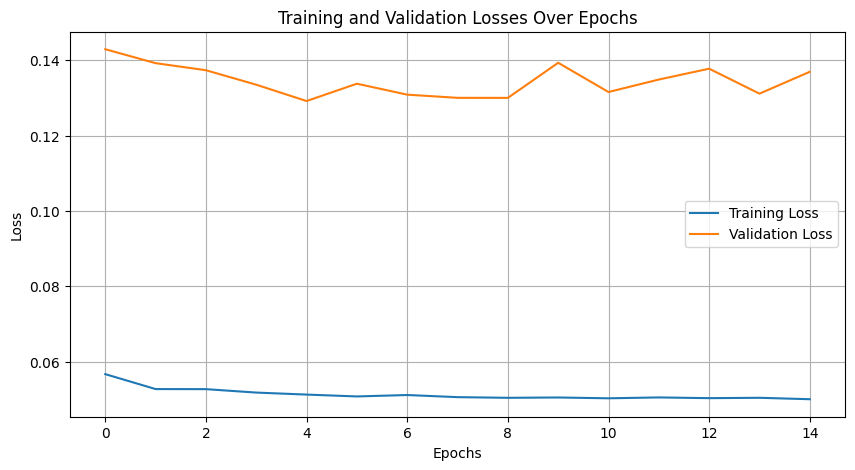

In [127]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
if valid_losses:
    plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [122]:
actual_counts[10000]

array([0., 0., 0., 0., 0., 0.], dtype=float32)

In [123]:
predicted_counts[10000]

array([0.51274455, 0.44537413, 0.82610095, 0.44894266, 0.47655916,
       0.39484984], dtype=float32)

In [47]:
def to_count(x):
    """predictions to integer counts"""
    # return np.rint(x).astype(int)   
    # rounded_predictions = np.where(x < 0.7, 0, np.rint(x).astype(int))
    # rounded_predictions = np.where(x < 0.7, 0, x)
    rounded_predictions = np.where(x < 0, 0, x)
    return rounded_predictions

In [57]:
# get predictions and loss for test dataset
_, test_predictions = evaluate_model(model, test_loader, criterion, return_predictions=True, weight_non_zero=10)

MAE: 0.0015673744
RMSE: 0.03959008
R-squared: 0.4489520490169525


In [44]:
# Calculate the number of sequences in the dataset
num_sequences = len(sequential_features)

# Calculate the split index
split_index = int(num_sequences * 0.9)  # 60% of the data for training

In [45]:
# 'timestamp' is the first column and the rest are recorder counts
timestamps = aggregated_data['timestamp']
test_timestamps = timestamps[split_index:-10]
len(test_timestamps)

7570

In [563]:
test_predictions[1]

tensor([-0.0163, -0.0071,  0.0216,  0.0017,  0.0017,  0.0215])

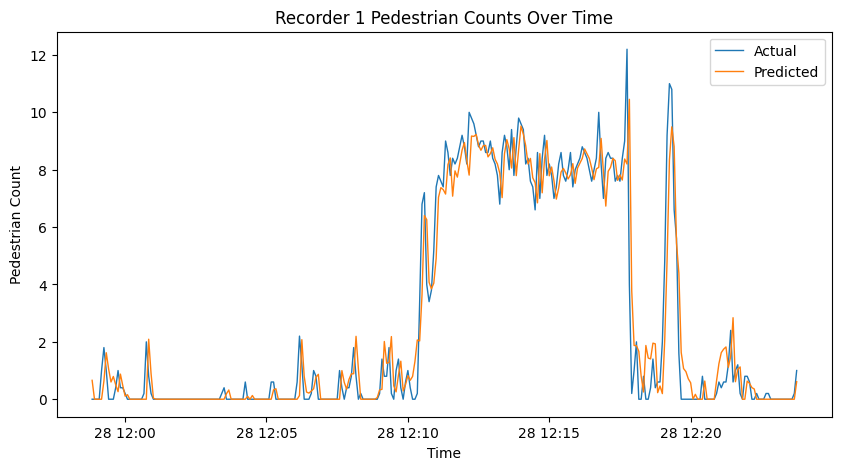

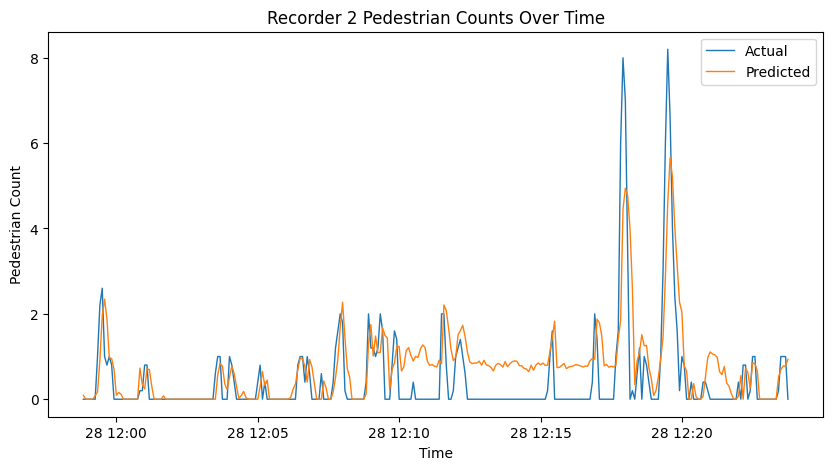

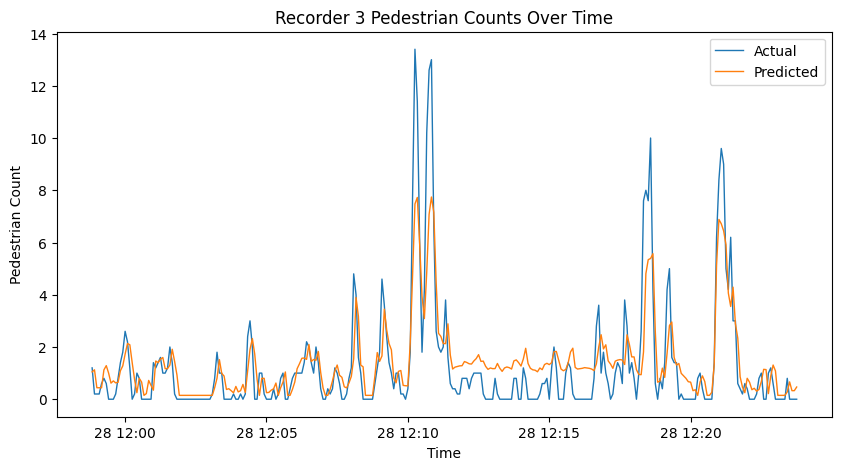

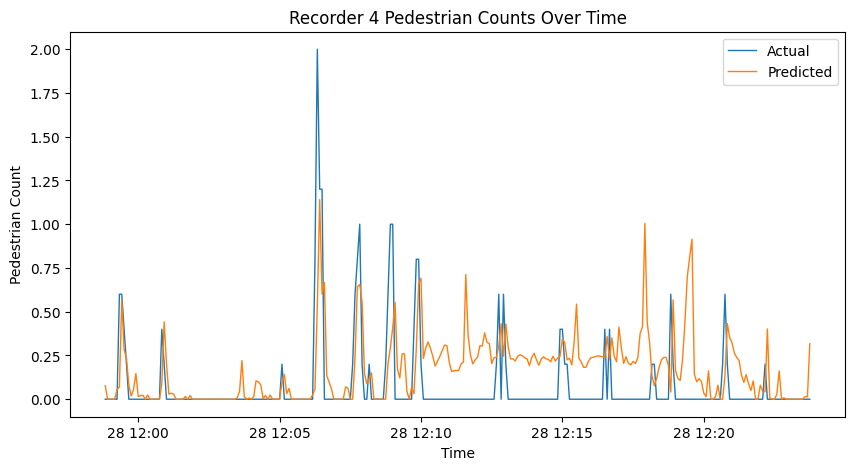

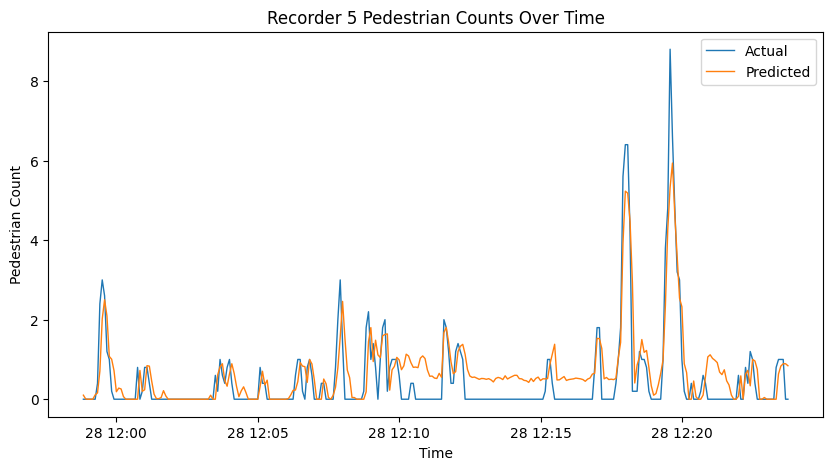

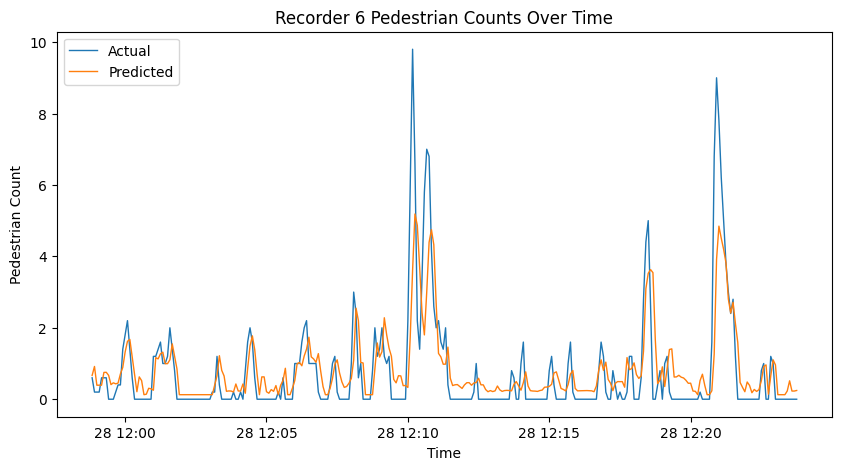

In [48]:
## import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Reverse scaling for both predictions and actual targets
actual_counts = reverse_min_max_scale(test_targets.numpy(), targets_min, targets_max)
predicted_counts = reverse_min_max_scale(test_predictions.numpy(), targets_min, targets_max)
predicted_counts = to_count(predicted_counts)
        
# plot_actual = actual_counts
# plot_predicted = predicted_counts
# plot_timestamp = test_timestamps

plot_actual = actual_counts[1300:1600]
plot_predicted = predicted_counts[1300:1600]
plot_timestamp = test_timestamps[1300:1600]

# Plot actual vs. predicted for each recorder
for i in range(6):  # Assuming there are 6 recorders
    plt.figure(figsize=(10, 5))
    plt.plot(plot_timestamp, plot_actual[:, i], label='Actual', linewidth=1)
    plt.plot(plot_timestamp, plot_predicted[:, i], label='Predicted',linewidth=1)
    # plt.bar(range(data['timestamp'].index.size), actual_counts[:, i], label='Actual', width=1)
    # plt.xlim([data['timestamp'].min(), data['timestamp'].max()])

    plt.title(f'Recorder {i+1} Pedestrian Counts Over Time')
    plt.xlabel('Time')
    plt.ylabel('Pedestrian Count')
    
    plt.legend()
    plt.show()


In [614]:
# Assuming predicted_counts is your numpy array
np.save('5s_gcn_predicted_counts.npy', predicted_counts)  # Saves the array to a binary .npy file

# Assuming timestamps is your pandas Series
test_timestamps.to_csv('5s_gcn_test_timestamps.csv', index=False)  # Saves the timestamps to a CSV file

# Video Visuaslization

In [594]:
time = pd.DataFrame(test_timestamps)
time['timestamp'] = pd.to_datetime(time['timestamp'])

time_array = time['timestamp'].values
time_array

array(['2023-05-28T10:10:30.000000000', '2023-05-28T10:10:35.000000000',
       '2023-05-28T10:10:40.000000000', ...,
       '2023-05-28T20:41:05.000000000', '2023-05-28T20:41:10.000000000',
       '2023-05-28T20:41:15.000000000'], dtype='datetime64[ns]')

In [595]:
predicted_counts

array([[0.        , 0.        , 0.        , 0.05509366, 0.01946943,
        0.0613131 ],
       [0.        , 0.        , 0.00782323, 0.04772605, 0.0781949 ,
        0.30415678],
       [0.        , 0.        , 0.        , 0.05509366, 0.01946943,
        0.0613131 ],
       ...,
       [0.        , 0.01652236, 1.0985775 , 0.        , 0.22318627,
        1.3799591 ],
       [0.        , 0.00991423, 1.2442969 , 0.        , 0.2125949 ,
        1.4409792 ],
       [0.        , 0.        , 0.6453739 , 0.030255  , 0.15488808,
        0.8925381 ]], dtype=float32)

In [599]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 8.1 MB/s eta 0:00:0000:0100:01


In [605]:
!pip install --upgrade nbformat

  Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.35.1-py3-none-any.whl.metadata (2.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 6.1 MB/s eta 0:00:00
Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl (18 kB)
Using cached referencing-0.35.1-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 5.7 MB/s eta 0:00:00a 0:00:01


In [607]:
import plotly
import plotly.graph_objects as go
import nbformat

locations = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']

fig = go.Figure(
    data=[go.Bar(x=locations, y=plot_predicted[0])],
    layout=go.Layout(
        title="Pedestrian Counts Over Time",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 500, "redraw": True},
                                       "fromcurrent": True, "transition": {"duration": 300, "easing": "quadratic-in-out"}}]),
                     dict(label="Pause",
                          method="animate",
                          args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate",
                                         "transition": {"duration": 0}}])
                     ])])
)

frames = [go.Frame(data=[go.Bar(x=locations, y=plot_predicted[i])], name=str(i*5)) for i in range(len(plot_predicted))]
fig.frames = frames
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [612]:
import subprocess
import ffmpeg

locations = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']

plot_actual = actual_counts[1300:1600]
plot_predicted = predicted_counts[1300:1600]
plot_timestamp = time_array[1300:1600]

for index, counts in enumerate(plot_predicted):
    plt.figure(figsize=(10, 6))
    plt.bar(locations, counts, color='royalblue')
    plt.xlabel('Locations')
    plt.ylabel('Pedestrian Count')
    plt.title(f'Pedestrian Count at T={index*5} seconds')
    plt.ylim(0, predicted_counts.max() + 0.5)  # Adjust as necessary
    plt.savefig(f'./frames/frame_{index:04d}.png')
    plt.close()
    
# Define the command as a string
command = "ffmpeg -framerate 1 -i ./frames/frame_%04d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ./output/output.mp4"

# Use subprocess to execute the commanda
subprocess.run(command, shell=True)

/bin/sh: ffmpeg: command not found


CompletedProcess(args='ffmpeg -framerate 1 -i ./frames/frame_%04d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ./output/output.mp4', returncode=127)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import os

# Sample data
data = pd.DataFrame({
    'Time': time_array,
    'Loc1': [10, 20, 15],
    'Loc2': [20, 15, 10],
    # Add other locations
})

# Coordinates of locations
locations = {
    'Loc1': (longitude1, latitude1),
    'Loc2': (longitude2, latitude2),
    # Add other locations
}

# Create plots for each time step
for index, row in data.iterrows():
    fig, ax = plt.subplots()
    m = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c', ax=ax)
    m.drawcoastlines()

    # Plot each location
    for loc, (lon, lat) in locations.items():
        x, y = m(lon, lat)
        size = row[loc]  # Assuming the count affects the size of the dot
        m.scatter(x, y, s=size, label=f'{loc}: {size}')

    plt.legend()
    plt.title(f'Time: {row["Time"]}')
    plt.savefig(f'frame_{index}.png')
    plt.close()

# Convert to GIF using ImageMagick (run this command in the same directory where your images are saved)
os.system('convert -delay 20 -loop 0 frame_*.png animation.gif')
